In [68]:
import sys
from pathlib import Path
import pandas as pd
import os
from IPython.display import display, Markdown  # Assuming you use these for display


# Set pandas display options to show more columns and rows
pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', 10)       # Limit to 10 rows for readability
pd.set_option('display.width', 2000) 

SOURCE_PATH = r'output\backtest_results\df_backtest_parameter_performance.parquet'

import pandas as pd
df = pd.read_parquet(SOURCE_PATH)
print(df)



         run_timestamp                          log_file selection_date actual_selection_date_used scheme  n_select_requested inv_vol_col_name  filter_min_price  filter_min_avg_volume_m  filter_min_roe_pct  filter_max_debt_eq  score_weight_rsi  score_weight_change  score_weight_rel_volume  score_weight_volatility  n_select_actual  portfolio_return  portfolio_return_normalized  num_attempted_trades  num_successful_trades  num_failed_or_skipped_trades  total_weight_traded  win_rate  average_return  std_dev_return  sharpe_ratio_period
0  2025-05-14 15:54:33  backtest_run_20250514_155433.log     2025-05-14                       None     EW                  10      ATR/Price %              10.0                      2.0                 5.0                 1.5              0.35                 0.35                      0.2                      0.1               10               NaN                          NaN                   NaN                      0                           NaN         

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   run_timestamp                 42 non-null     datetime64[us]
 1   log_file                      42 non-null     object        
 2   selection_date                42 non-null     object        
 3   actual_selection_date_used    36 non-null     object        
 4   scheme                        42 non-null     object        
 5   n_select_requested            42 non-null     int64         
 6   inv_vol_col_name              42 non-null     object        
 7   filter_min_price              42 non-null     float64       
 8   filter_min_avg_volume_m       42 non-null     float64       
 9   filter_min_roe_pct            42 non-null     float64       
 10  filter_max_debt_eq            42 non-null     float64       
 11  score_weight_rsi              42 n

In [70]:
risk_free_daily_rate = 0.04 / 365

In [71]:
import pandas as pd
import numpy as np

# Assuming your DataFrame is named df
# If you need to load your data, you would do it here, e.g.:
# df = pd.read_csv('your_data.csv')
# df['run_timestamp'] = pd.to_datetime(df['run_timestamp']) # Convert timestamp if necessary

# --- Start of code to address the user request ---

# 1. Determine aggregate portfolio_return in df by scheme
# The aggregate portfolio return is typically the mean of the portfolio returns over the period for each scheme.
aggregate_portfolio_return = df.groupby('scheme')['portfolio_return'].mean()

# 2. Calculate the Sharpe ratio for each scheme.
# The Sharpe Ratio is calculated as (Rp - Rf) / sigma_p
# Where:
# Rp = Portfolio Return (we will use the mean portfolio return for each scheme)
# Rf = Risk-Free Rate (assuming 0 for simplicity as it's not provided in df.info())
# sigma_p = Standard Deviation of Portfolio Returns (we will use the standard deviation of portfolio_return for each scheme)

# Calculate the standard deviation of portfolio returns for each scheme
std_dev_portfolio_return = df.groupby('scheme')['portfolio_return'].std()

# Calculate the Sharpe Ratio
# Handle the case where standard deviation might be 0 to avoid division by zero
sharpe_ratio = (aggregate_portfolio_return - risk_free_daily_rate) / std_dev_portfolio_return.replace(0, np.nan)

# --- End of code to address the user request ---

# Print the results
print("Aggregate Portfolio Return by Scheme:")
print(aggregate_portfolio_return)

print(f"\nSharpe Ratio by Scheme (assuming Risk-Free Rate = {risk_free_daily_rate:.5f}):")
print(sharpe_ratio)

# Multiplying the daily Sharpe Ratio by sqrt(T) (e.g., sqrt(252)) 
# is a standard and widely accepted industry practice for annualization.
# These annualized Sharpe Ratios are exceptionally high. 
# A sustained Sharpe Ratio above 1 is generally good, 
# above 2 is very good, and above 3 is excellent. 
# Values above 6 are almost unheard of for liquid, scalable strategies over long periods, 
# suggesting either a phenomenal strategy, a very specific market regime, 
# a short backtest period, or potential issues with the backtest 
# (like overfitting, look-ahead bias, or not including costs).
print(f'\nAnnualized Sharpe Ratio by Scheme (assuming 252 trading days):')
print(sharpe_ratio * np.sqrt(252))

Aggregate Portfolio Return by Scheme:
scheme
EW    0.003852
IV    0.003269
SW    0.004261
Name: portfolio_return, dtype: float64

Sharpe Ratio by Scheme (assuming Risk-Free Rate = 0.00011):
scheme
EW    0.245760
IV    0.231482
SW    0.267542
Name: portfolio_return, dtype: float64

Annualized Sharpe Ratio by Scheme (assuming 252 trading days):
scheme
EW    3.901317
IV    3.674669
SW    4.247101
Name: portfolio_return, dtype: float64


Running example with: annual_rfr=0.04, trading_days_per_year=252, min_periods_for_sharpe=10


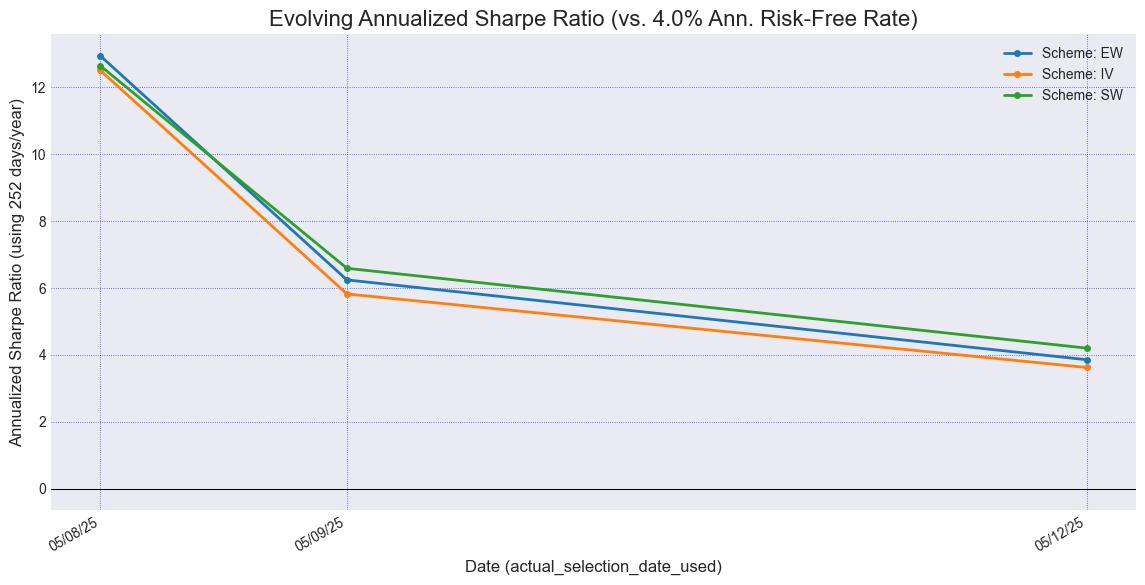


Sample of results (Scheme EW around min_periods mark):
         run_timestamp                          log_file selection_date actual_selection_date_used scheme  n_select_requested inv_vol_col_name  filter_min_price  filter_min_avg_volume_m  filter_min_roe_pct  filter_max_debt_eq  score_weight_rsi  score_weight_change  score_weight_rel_volume  score_weight_volatility  n_select_actual  portfolio_return  portfolio_return_normalized  num_attempted_trades  num_successful_trades  num_failed_or_skipped_trades  total_weight_traded  win_rate  average_return  std_dev_return  sharpe_ratio_period  expanding_mean_return  expanding_std_return  daily_sharpe_ratio  annualized_sharpe_ratio
18 2025-05-14 15:54:33  backtest_run_20250514_155433.log     2025-05-06                 2025-05-06     EW                  10      ATR/Price %              10.0                      2.0                 5.0                 1.5              0.35                 0.35                      0.2                      0.1  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.dates import DateFormatter # Import DateFormatter

def plot_evolving_annualized_sharpe(df,
                                    date_col,
                                    return_col,
                                    scheme_col,
                                    annual_risk_free_rate,
                                    trading_days_per_year=252,
                                    min_periods_for_sharpe=10):
    """
    Calculates and plots the evolving annualized Sharpe Ratio for different schemes.

    The function processes a DataFrame of daily returns, calculates the expanding
    mean and standard deviation of these returns for each scheme, and then
    computes the daily and annualized Sharpe Ratios. The results are plotted
    over time, showing how the risk-adjusted performance of each scheme evolves.

    Dates on the x-axis are normalized (time component removed) and ticks are
    set explicitly to the dates where data points are plotted to avoid
    duplicate or misleading date labels. Lines include markers for clarity.

    Args:
        df (pd.DataFrame): DataFrame containing the daily return data.
                           Must have date, scheme, and daily return columns.
                           The date column should contain datetime-like objects.
        date_col (str): Name of the column containing dates.
        return_col (str): Name of the column containing daily portfolio returns.
        scheme_col (str): Name of the column containing the scheme identifiers
                          (e.g., 'EW', 'IV', 'SW').
        annual_risk_free_rate (float): The annualized risk-free rate
                                       (e.g., 0.04 for 4%).
        trading_days_per_year (int, optional): Number of trading days in a year
                                               used for annualization and for
                                               calculating the daily risk-free rate.
                                               Defaults to 252.
        min_periods_for_sharpe (int, optional): Minimum number of data points
                                                required to calculate the
                                                expanding mean and standard deviation,
                                                and thus the Sharpe ratio.
                                                Standard deviation requires at least 2.
                                                Higher values can make initial
                                                Sharpe ratios more stable.
                                                Defaults to 10.

    Returns:
        pd.DataFrame: A DataFrame containing the original data along with the
                      calculated expanding mean return, expanding standard
                      deviation, daily Sharpe ratio, and annualized Sharpe ratio
                      for each data point where calculable. Returns an empty
                      DataFrame if no data can be processed or plotted.

    Raises:
        ValueError: If input `df` is not a pandas DataFrame, if essential columns
                    are missing, or if `trading_days_per_year` or
                    `min_periods_for_sharpe` are invalid.

    Output:
        A matplotlib plot showing the evolving annualized Sharpe ratio for each
        scheme over time.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input 'df' must be a pandas DataFrame.")
    if not all(col in df.columns for col in [date_col, return_col, scheme_col]):
        raise ValueError(f"DataFrame must contain columns: {date_col}, {return_col}, {scheme_col}")
    if not isinstance(trading_days_per_year, int) or trading_days_per_year <= 0:
        raise ValueError("trading_days_per_year must be a positive integer.")
    if not isinstance(min_periods_for_sharpe, int) or min_periods_for_sharpe < 2:
        raise ValueError("min_periods_for_sharpe must be an integer greater than or equal to 2.")

    # --- 1. Data Preparation ---
    df_analysis = df.copy()
    # Normalize dates early to ensure consistency and remove time components
    df_analysis[date_col] = pd.to_datetime(df_analysis[date_col]).dt.normalize()
    df_analysis = df_analysis.dropna(subset=[date_col]) # Remove rows if date became NaT
    df_analysis = df_analysis.sort_values(by=[scheme_col, date_col])


    # --- 2. Calculate Daily Risk-Free Rate ---
    daily_risk_free_rate = annual_risk_free_rate / trading_days_per_year

    # --- 3. Calculate Evolving Metrics and Sharpe Ratio ---
    results_list = []
    for scheme_name, group in df_analysis.groupby(scheme_col):
        group['expanding_mean_return'] = group[return_col].expanding(min_periods=min_periods_for_sharpe).mean()
        group['expanding_std_return'] = group[return_col].expanding(min_periods=min_periods_for_sharpe).std()

        numerator = group['expanding_mean_return'] - daily_risk_free_rate
        denominator = group['expanding_std_return']

        group['daily_sharpe_ratio'] = np.where(
            (denominator > 1e-9) & (denominator.notna()),
            numerator / denominator,
            np.nan
        )
        group['annualized_sharpe_ratio'] = group['daily_sharpe_ratio'] * np.sqrt(trading_days_per_year)
        results_list.append(group)

    if not results_list:
        print("Warning: No data after processing. Cannot generate plot.")
        return pd.DataFrame()
        
    df_results = pd.concat(results_list)

    # --- 4. Plotting ---
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(14, 7))

    schemes = df_results[scheme_col].unique()
    all_plotted_dates_objects = [] # To collect dates that actually have data points

    for scheme in schemes:
        subset = df_results[df_results[scheme_col] == scheme]
        # Date column is already normalized. Drop rows if Sharpe is NaN or date is NaT
        subset_plot = subset.dropna(subset=['annualized_sharpe_ratio', date_col])

        if not subset_plot.empty:
            # Added marker to clearly show data points
            ax.plot(subset_plot[date_col], subset_plot['annualized_sharpe_ratio'],
                    label=f"Scheme: {scheme}", linewidth=2, marker='o', markersize=4)
            all_plotted_dates_objects.extend(subset_plot[date_col].tolist())

    ax.set_title(f'Evolving Annualized Sharpe Ratio (vs. {annual_risk_free_rate*100:.1f}% Ann. Risk-Free Rate)', fontsize=16)
    ax.set_xlabel(f'Date ({date_col})', fontsize=12)
    ax.set_ylabel(f'Annualized Sharpe Ratio (using {trading_days_per_year} days/year)', fontsize=12)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(fontsize=10)
    else:
        ax.text(0.5, 0.5, 'No data to plot (check min_periods_for_sharpe or data length)',
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes, fontsize=12, color='red')

    # alpha: A float value between 0.0 and 1.0, inclusive, alpha=1.0: Completely opaque color
    ax.grid(True, which='both', color='blue', linestyle=':', linewidth=0.6, alpha=0.7)  
    ax.axhline(0, color='black', linestyle='-', linewidth=0.75)

    # --- Apply custom date formatting and set x-axis ticks explicitly ---
    if all_plotted_dates_objects:
        # Get unique sorted dates from all plotted data
        unique_plotted_dates = sorted(list(pd.Series(all_plotted_dates_objects).unique()))
        unique_plotted_dates = [pd.Timestamp(d) for d in unique_plotted_dates if pd.notna(d)] # Ensure Timestamps

        if unique_plotted_dates:
            ax.set_xticks(unique_plotted_dates) # Set ticks ONLY to these dates
            date_form = DateFormatter("%m/%d/%y") # Your requested format "mm/dd/yy"
            ax.xaxis.set_major_formatter(date_form)
            # Auto-format x-axis labels for better layout (rotation, alignment)
            fig.autofmt_xdate(rotation=30, ha='right')
        else:
            ax.set_xticks([]) # Clear any default ticks if no valid dates
            print("Warning: No valid dates found to set x-axis ticks after filtering.")
    else: # No data plotted at all
        ax.set_xticks([])


    # fig.tight_layout() # autofmt_xdate usually handles necessary adjustments
    plt.show()

    return df_results


# Parameters from the image title
annual_rfr_example = 0.04  # 4% annual risk-free rate
custom_trading_days_example = 252
custom_min_periods_example = 10 # As in the image (though image data seems to start plotting earlier)

print(f"Running example with: annual_rfr={annual_rfr_example}, trading_days_per_year={custom_trading_days_example}, min_periods_for_sharpe={custom_min_periods_example}")
# print(f"Example data has {num_total_data_points} days per scheme, expecting {num_total_data_points - custom_min_periods_example + 1} plottable Sharpe points.")

results_df = plot_evolving_annualized_sharpe(
    df=df,
    date_col='actual_selection_date_used',
    return_col='portfolio_return',
    scheme_col='scheme',
    annual_risk_free_rate=annual_rfr_example,
    trading_days_per_year=custom_trading_days_example,
    min_periods_for_sharpe=custom_min_periods_example
)

if not results_df.empty:
    print("\nSample of results (Scheme EW around min_periods mark):")
    ew_results = results_df[results_df['scheme']=='EW']
    # Show data points including the first few NaNs and the first few calculated Sharpe ratios
    print(ew_results.iloc[custom_min_periods_example - 3 : custom_min_periods_example + 3])